### Portfolio Analysis based on your Risk Aversion level and timeframe
We have 3 levels of Risk Aversion, with level 3 being the most aggressive
We have 3 timeframes for which we will do our Monte Carlo forecasts: 5, 10, and 20 years.

In [1]:
# Import the required libraries and dependencies
#import questionary   #Tried to include this and didn't work
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [3]:
#User inputs 
while True:
    try:
        portfolio_value = input("To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': \n")
    
        if portfolio_value == 'Quit':
            print('You have quit the program. Have a nice day.')
            
            break
        
        portfolio_value = float(portfolio_value)
        
        if portfolio_value < 1000000:
            print("Unfortunately, you do not have enough savings to invest in a portfolio. \nThe minimum required is $1,000,000.")
    
        break
    except ValueError:
        print("Please only enter numerical digits.")

    



To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': 
 5000000


In [4]:
#portfolio_value = 1000000 #we assume client gives us 1mm to start with.

In [5]:
#Get user input for risk tolerance. User must input 1, 2, or 3. If risk_tolerance is not one of these, we prompt user
#to try again.
risk_tolerance = input("Please select your risk tolerance level from 1-3, 3 being the most aggressive: ")
#print(risk_tolerance)
#type if statment here
if int(risk_tolerance) == 1:
    print("Thank you for your response!  You are a conversative investor.")
    tickers = ["JPM","VTEB","PZA","BNDX","GOOGL"]
    #JP Morgan, Vanguard Tax-Exempt Bond Index Fund ETF, Invesco National AMT-Free Municipal Bond ETF, Vanguard Total International Bond Index Fund
    #Google
elif int(risk_tolerance) == 2:
    print("Thank you for your response!  You are an aggressive investor.")
    tickers = ["FB","AAPL","TSLA","RDS.A","GS"]
    #Facebook, Apple, Tesla, Shell Oil, Goldman Sachs
elif int(risk_tolerance) == 3:
    print("Thank you for your response!  You are a very aggressive investor.")
    tickers = ["NFLX","ADBE","AMZN","PYPL","GME"]
    #Netflix, Adobe, Amazon, Paypal, GameStop

else:
    print("I'm sorry, you need to enter 1, 2, or 3 for the application to work.")
#chaim edit- changed the print function to simplify output
risk_tolerance = int(risk_tolerance) #force it to be a number since the result of input() is a string
print(f"The stocks on your portfolio will be {tickers}")


    

Please select your risk tolerance level from 1-3, 3 being the most aggressive:  2


Thank you for your response!  You are an aggressive investor.
The stocks on your portfolio will be ['FB', 'AAPL', 'TSLA', 'RDS.A', 'GS']


In [6]:
#Changed 2021-11-02 by Paul Lopez. We are running all time horizon scenarios to show the client the confidence intervals
# for 5, 10, and 20yrs and will output it to a CSV file if the client wants. Chaim's idea. You are welcome.

#time_horizon = input("Please select your time horizon for the forecast: 5, 10, or 20 years?")
#print(f"Thank you for your input! Your holding period will be {time_horizon} years")
#time_horizon = int(time_horizon) #forcing it to be an int
#chaim edit- changed print function to simplify output
#type if statement here if time_horizon is not 5, 10, or 20 we prompt the user to try again

In [7]:
# Set the variables for the Alpaca API and secret keys. Will be making calls for historical prices.
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


str

str

In [8]:
# Set the tickers for both the bond and stock portion of the portfolio

#This setting of tickers will also need to be made a bit more dynamic again dep on what client selects
#We know this would be risk tolerance level 2 based on Nev's list.
#tickers = ["FB","AAPL","TSLA","RDS.A","GS"] Paul Lopez moved this up on 2021-10-29 to the top depending on if client enters 1, 2, or 3 for risk tolerance

# Set timeframe to 1D 
timeframe = "1D"

# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
start_date = pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
limit_rows = 1000
#We can possibly make this start and end date a bit more dynamic by just pulling today's or yesterday's
#date and feeding in here as a variable.

In [9]:
# We use the Alpaca get_barset function to get current closing prices for our portfolio of 5 tickers
prices_df = alpaca.get_barset(tickers, timeframe, start=start_date, end=end_date, limit=limit_rows).df

# checking dataframe to make sure everything looks ok for our closes
prices_df.head()


AAPL                                        FB  \
                             open    high     low   close    volume    open   
time                                                                          
2021-10-27 00:00:00-04:00  149.38  149.73  148.49  148.85  43068962  314.11   

                                                             ... RDS.A         \
                             high     low   close    volume  ...  open   high   
time                                                         ...                
2021-10-27 00:00:00-04:00  319.25  312.06  312.22  27016324  ...  48.6  50.75   

                                                      TSLA                    \
                             low  close    volume     open     high      low   
time                                                                           
2021-10-27 00:00:00-04:00  48.37  49.97  16561341  1038.78  1070.88  1030.78   

                                           
                          close    volume  
time                                       
2021-10-27 00:00:00-04:00  1038  35678057  

[1 rows x 25 columns]

In [10]:
# Access the closing prices for our 5 tickers from the Alpaca DataFrame
# We also convert the value to a floating point number
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
stock1_close_price = float(prices_df[tickers[0]]["close"])
stock2_close_price = float(prices_df[tickers[1]]["close"])
stock3_close_price = float(prices_df[tickers[2]]["close"])
stock4_close_price = float(prices_df[tickers[3]]["close"])
stock5_close_price = float(prices_df[tickers[4]]["close"])

display(stock1_close_price)
display(stock2_close_price)
display(stock3_close_price)
display(stock4_close_price)
display(stock5_close_price)

#fb_close_price = float(prices_df["FB"]["close"])
#aapl_close_price = float(prices_df["AAPL"]["close"])
#tsla_close_price = float(prices_df["TSLA"]["close"])
#rdsa_close_price = float(prices_df["RDS.A"]["close"])
#gs_close_price = float(prices_df["GS"]["close"])

# Print the AGG closing price
#display(fb_close_price)
#display(aapl_close_price)
#display(tsla_close_price)
#display(rdsa_close_price)
#display(gs_close_price)


312.22

148.85

1038.0

49.97

411.06

In [11]:
# Calculate the current value of the bond portion of the portfolio
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
value_per_share = portfolio_value/5 #we assume 1 million dollar investment, and 200k per share.
stock1_shares = value_per_share / stock1_close_price
stock2_shares = value_per_share / stock2_close_price
stock3_shares = value_per_share / stock3_close_price
stock4_shares = value_per_share / stock4_close_price
stock5_shares = value_per_share / stock5_close_price

# Print how many shares we get of each stock assuming 200k is available for each one.
print(f"With ${value_per_share:.2f} you will be able to purchase {stock1_shares:.0f} shares of {tickers[0]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock2_shares:.0f} shares of {tickers[1]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock3_shares:.0f} shares of {tickers[2]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock4_shares:.0f} shares of {tickers[3]}.")
print(f"With ${value_per_share:.2f} you will be able to purchase {stock5_shares:.0f} shares of {tickers[4]}.")


With $1000000.00 you will be able to purchase 3203 shares of FB.
With $1000000.00 you will be able to purchase 6718 shares of AAPL.
With $1000000.00 you will be able to purchase 963 shares of TSLA.
With $1000000.00 you will be able to purchase 20012 shares of RDS.A.
With $1000000.00 you will be able to purchase 2433 shares of GS.


In [12]:
# Set start and end dates of 10 years back from your current date
#We'll always assume 10 years back. Again we can make this dynamic if we want
#and start with yesterday's date and then go back 10 years.
start_date = pd.Timestamp("2011-10-28", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-10-28", tz="America/New_York").isoformat()

limit_rows = 1000

In [13]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Display both the first and last five rows of the DataFrame
display(prices_df.head(2))
display(prices_df.tail(2))
tickers

AAPL                         FB                 \
                          open high low close volume open high low close   
time                                                                       
2017-10-16 00:00:00-04:00  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN   
2017-10-17 00:00:00-04:00  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN   

                                  ...  RDS.A                                   \
                          volume  ...   open   high    low   close     volume   
time                              ...                                           
2017-10-16 00:00:00-04:00    NaN  ...  61.24  61.29  60.87  60.875  2191500.0   
2017-10-17 00:00:00-04:00    NaN  ...  60.98  60.99  60.49  60.690  2042981.0   

                          TSLA                        
                          open high low close volume  
time                                                  
2017-10-16 00:00:00-04:00  NaN  NaN NaN   NaN    NaN  
2017-10-17 00:00:00-04:00  NaN  NaN NaN   NaN    NaN  

[2 rows x 25 columns]

AAPL                                         \
                             open     high     low     close      volume   
time                                                                       
2021-10-27 00:00:00-04:00  149.38  149.730  148.49  148.8500  43201783.0   
2021-10-28 00:00:00-04:00  149.86  153.165  149.72  152.4766  77772052.0   

                               FB                                      ...  \
                             open    high     low   close      volume  ...   
time                                                                   ...   
2021-10-27 00:00:00-04:00  314.11  319.25  312.06  312.22  27016319.0  ...   
2021-10-28 00:00:00-04:00  312.81  325.52  308.11  316.82  48061660.0  ...   

                          RDS.A                                          TSLA  \
                           open     high      low  close      volume     open   
time                                                                            
2021-10-27 00:00:00-04:00  48.6  50.7500  48.3700  49.97  16569596.0  1038.78   
2021-10-28 00:00:00-04:00  48.0  48.0608  46.8114  47.44  12632678.0  1068.03   

                                                                  
                              high      low    close      volume  
time                                                              
2021-10-27 00:00:00-04:00  1070.88  1030.78  1038.00  35678056.0  
2021-10-28 00:00:00-04:00  1081.00  1054.20  1077.09  24517641.0  

[2 rows x 25 columns]

['FB', 'AAPL', 'TSLA', 'RDS.A', 'GS']

###Here we run a Monte Carlo simulation of 1000 samples and the time frame could be 5, 10, or 20 years depending on the user's response. We always will assume equal 20% weight for each stock in the portfolio.

In [14]:
# Configure the Monte Carlo simulation to forecast cumulative returns based on the client's input.

#Changed 2021-11-02. We will run 3 scenarios of 5yr, 10yr, and 20yr.
# The weights we will assume will be split evenly 20 percent for each ticker.
# We will be running 1000 samples.
MC_even_weight_5yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 1000,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*5 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 5 now
)

# Review the simulation input data
MC_even_weight_5yr.portfolio_data.head()


AAPL                                      FB       \
                          open high low close volume daily_return open high   
time                                                                          
2017-10-16 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-17 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-18 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-19 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-20 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   

                                     ...  RDS.A                     \
                          low close  ...    low   close     volume   
time                                 ...                             
2017-10-16 00:00:00-04:00 NaN   NaN  ...  60.87  60.875  2191500.0   
2017-10-17 00:00:00-04:00 NaN   NaN  ...  60.49  60.690  2042981.0   
2017-10-18 00:00:00-04:00 NaN   NaN  ...  60.43  60.530  2460564.0   
2017-10-19 00:00:00-04:00 NaN   NaN  ...  60.81  61.040  2857213.0   
2017-10-20 00:00:00-04:00 NaN   NaN  ...  60.92  61.070  2174961.0   

                                       TSLA                                     
                          daily_return open high low close volume daily_return  
time                                                                            
2017-10-16 00:00:00-04:00          NaN  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-17 00:00:00-04:00    -0.003039  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-18 00:00:00-04:00    -0.002636  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-19 00:00:00-04:00     0.008426  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-20 00:00:00-04:00     0.000491  NaN  NaN NaN   NaN    NaN          NaN  

[5 rows x 30 columns]

In [15]:
MC_even_weight_10yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 1000,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*10 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 10 now
)

MC_even_weight_10yr.portfolio_data.head()

AAPL                                      FB       \
                          open high low close volume daily_return open high   
time                                                                          
2017-10-16 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-17 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-18 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-19 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-20 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   

                                     ...  RDS.A                     \
                          low close  ...    low   close     volume   
time                                 ...                             
2017-10-16 00:00:00-04:00 NaN   NaN  ...  60.87  60.875  2191500.0   
2017-10-17 00:00:00-04:00 NaN   NaN  ...  60.49  60.690  2042981.0   
2017-10-18 00:00:00-04:00 NaN   NaN  ...  60.43  60.530  2460564.0   
2017-10-19 00:00:00-04:00 NaN   NaN  ...  60.81  61.040  2857213.0   
2017-10-20 00:00:00-04:00 NaN   NaN  ...  60.92  61.070  2174961.0   

                                       TSLA                                     
                          daily_return open high low close volume daily_return  
time                                                                            
2017-10-16 00:00:00-04:00          NaN  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-17 00:00:00-04:00    -0.003039  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-18 00:00:00-04:00    -0.002636  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-19 00:00:00-04:00     0.008426  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-20 00:00:00-04:00     0.000491  NaN  NaN NaN   NaN    NaN          NaN  

[5 rows x 30 columns]

In [16]:
MC_even_weight_20yr = MCSimulation(
    portfolio_data = prices_df,
    weights = [0.2,0.2,0.2,0.2,0.2],
    num_simulation = 1000,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*20 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 20 now
)
MC_even_weight_20yr.portfolio_data.head()

AAPL                                      FB       \
                          open high low close volume daily_return open high   
time                                                                          
2017-10-16 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-17 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-18 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-19 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   
2017-10-20 00:00:00-04:00  NaN  NaN NaN   NaN    NaN          NaN  NaN  NaN   

                                     ...  RDS.A                     \
                          low close  ...    low   close     volume   
time                                 ...                             
2017-10-16 00:00:00-04:00 NaN   NaN  ...  60.87  60.875  2191500.0   
2017-10-17 00:00:00-04:00 NaN   NaN  ...  60.49  60.690  2042981.0   
2017-10-18 00:00:00-04:00 NaN   NaN  ...  60.43  60.530  2460564.0   
2017-10-19 00:00:00-04:00 NaN   NaN  ...  60.81  61.040  2857213.0   
2017-10-20 00:00:00-04:00 NaN   NaN  ...  60.92  61.070  2174961.0   

                                       TSLA                                     
                          daily_return open high low close volume daily_return  
time                                                                            
2017-10-16 00:00:00-04:00          NaN  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-17 00:00:00-04:00    -0.003039  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-18 00:00:00-04:00    -0.002636  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-19 00:00:00-04:00     0.008426  NaN  NaN NaN   NaN    NaN          NaN  
2017-10-20 00:00:00-04:00     0.000491  NaN  NaN NaN   NaN    NaN          NaN  

[5 rows x 30 columns]

In [17]:
# Run the Monte Carlo simulation to forecast client specified number of years of cumulative returns
#Changed on 2021-11-02 by Paul Lopez. Will now be running 5yr, 10yr, and 20yr MC scenarios.
MC_even_weight_5yr.calc_cumulative_return()

#Tweaked monte carlo py file to spit out a message every 200 simulations.

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 600.
Running Monte Carlo simulation number 800.


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.011381,1.016673,1.020783,1.012562,0.982432,1.014061,0.991567,0.997581,1.004314,1.009884,...,1.019440,1.034672,0.987878,0.995170,1.012612,1.021089,0.993879,1.005964,0.997240,0.982910
2,1.023555,1.020659,1.035280,1.030415,0.992475,1.009701,0.992698,0.988428,1.012356,1.002555,...,1.030244,1.034697,0.984845,1.027178,1.011104,1.016538,1.000891,1.002161,0.997482,0.981919
3,1.020003,1.030726,1.063587,1.050618,0.992570,1.005264,0.993976,0.985734,1.001958,1.013394,...,1.039024,1.072000,0.982526,1.007289,1.022942,1.010343,1.019969,0.994763,0.991514,0.970392
4,1.013409,1.003034,1.073194,1.071625,1.017455,1.018778,0.995242,1.003013,0.997953,1.036617,...,1.027565,1.073948,0.962812,1.023162,1.032799,0.992766,1.024735,1.003317,0.979305,0.986758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,6.382607,4.014563,1.569604,3.935604,8.471155,5.255906,3.499107,3.960811,3.153477,3.007023,...,1.687112,5.883397,1.536710,2.979121,2.662500,1.468864,8.249269,2.507169,2.694242,4.745900
1257,6.284139,3.961201,1.557901,3.947890,8.687730,5.262860,3.461476,3.981491,3.150490,2.993009,...,1.702115,6.028959,1.527016,3.025062,2.698898,1.465007,8.211201,2.503041,2.700000,4.800526
1258,6.294200,4.032943,1.559213,3.980838,8.580772,5.233765,3.471423,3.990911,3.081203,2.961557,...,1.725411,6.156393,1.535512,3.069870,2.652433,1.448918,8.213618,2.544921,2.715420,4.853729
1259,6.296240,4.058852,1.561661,3.948086,8.421812,5.171461,3.454712,4.003171,3.071428,2.903340,...,1.750448,6.153925,1.506168,3.052108,2.665443,1.444294,8.194338,2.600258,2.672831,4.918285


In [18]:
MC_even_weight_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 600.
Running Monte Carlo simulation number 800.


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008565,1.012851,1.002042,0.977056,1.009010,1.012479,0.988392,0.992967,0.993525,0.999292,...,1.015646,0.964264,0.996277,0.988518,1.003948,0.988127,0.989681,0.980246,0.987223,1.002289
2,0.976638,1.001528,0.998748,0.976025,1.023964,1.006949,0.988951,1.008281,1.006391,0.987966,...,1.037658,0.956074,1.006403,1.006440,1.017159,0.965510,0.970745,0.959135,0.999110,1.005079
3,0.970816,0.998479,1.002984,0.982910,1.036386,1.005379,0.993429,0.998014,0.994652,0.984646,...,1.027265,0.976745,1.006356,1.028453,1.002654,0.989278,0.983896,0.957639,1.012415,1.004723
4,0.952396,0.978018,1.011471,0.991696,1.058782,1.013548,1.007963,1.006707,0.999514,0.984354,...,1.024072,0.984638,0.998145,1.026643,1.000581,0.996562,0.971829,0.953577,1.040851,1.008967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,8.530456,10.947340,9.304322,7.733763,17.096189,2.790265,4.089374,8.068024,7.146403,30.642355,...,12.840797,1.142567,17.594202,2.887175,17.262149,9.148175,5.542261,5.271871,6.990093,5.895549
2517,8.380436,11.160495,9.373493,7.742721,16.960847,2.800415,4.100033,8.181805,7.188472,30.864728,...,12.822177,1.148426,17.777860,2.902453,17.369660,8.901871,5.511063,5.170848,7.111208,5.779593
2518,8.539075,11.137168,9.284884,7.834846,16.588844,2.766421,4.102398,7.984047,7.370334,30.991093,...,12.910068,1.142323,17.696331,2.873275,17.094275,9.067856,5.656906,5.117269,7.022794,5.778890
2519,8.619393,11.007858,9.202008,7.866190,16.721553,2.817993,4.111996,8.002419,7.399582,30.541608,...,13.099395,1.141315,17.457073,2.842513,16.887118,9.002244,5.619757,5.099605,7.117099,5.788783


In [19]:
MC_even_weight_20yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 600.
Running Monte Carlo simulation number 800.


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991961,1.000168,1.007901,1.013370,0.990376,1.003380,0.985118,1.017834,0.994398,0.986276,...,0.981715,1.025616,1.013947,1.004322,0.996386,0.986318,1.011321,0.995488,0.987141,1.015220
2,1.001647,1.029798,1.024530,1.036700,0.981664,1.001955,0.967075,1.010371,0.981205,0.971383,...,0.976439,1.008991,1.035645,0.992685,1.009009,1.000159,1.010106,1.007848,0.993918,1.050421
3,1.021527,1.038108,1.012566,1.021246,0.978999,1.009430,0.971501,1.019766,0.982059,0.974409,...,0.986567,0.990492,1.019098,0.995199,0.996467,0.993565,1.010193,1.022320,1.005835,1.063211
4,1.003649,1.036461,1.008086,1.014603,0.958897,1.031378,0.991364,1.024241,0.972703,0.987860,...,0.995597,0.981197,1.024307,0.969315,0.980072,1.001569,1.002587,1.017653,0.989240,1.083582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,324.078539,304.141141,56.317391,103.050446,81.092639,66.219353,155.764474,34.786240,228.856847,80.892622,...,263.208615,38.571708,97.227779,155.874467,39.499238,40.343345,38.124268,175.021671,218.874032,295.963763
5037,320.897914,300.801146,56.574750,105.518107,82.726195,67.075942,151.049937,35.375526,232.479852,80.001466,...,272.476914,38.238583,96.157353,153.837061,38.931829,40.148997,37.976771,178.764414,216.758671,299.589158
5038,319.095013,306.510598,57.122810,104.071936,81.739915,68.985396,148.343671,34.913834,233.751016,79.898161,...,269.102426,38.089621,98.961241,152.060107,38.861922,40.223244,38.164561,176.969067,216.874072,295.768494
5039,318.801805,307.070294,58.153985,105.305871,83.016068,69.497449,148.250885,35.087139,236.666027,80.750363,...,263.375368,38.022141,98.940589,152.957758,39.135262,39.718126,36.667831,178.541789,218.026724,296.736933


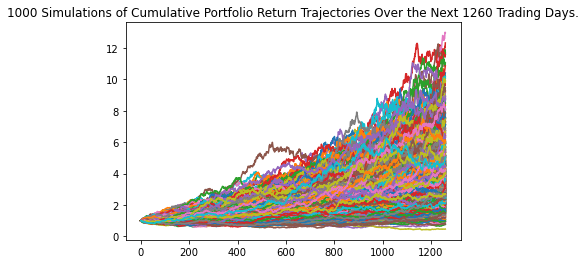

In [20]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 5yr scenario
MC_even_weight_line_5yr_plot = MC_even_weight_5yr.plot_simulation()


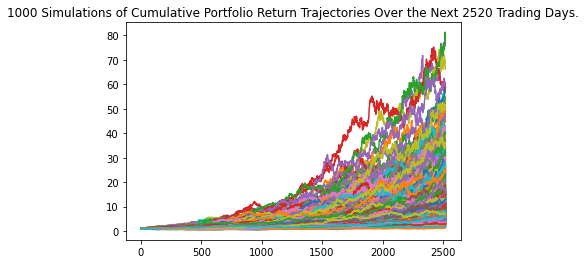

In [21]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 10yr scenario

MC_even_weight_line_10yr_plot = MC_even_weight_10yr.plot_simulation()

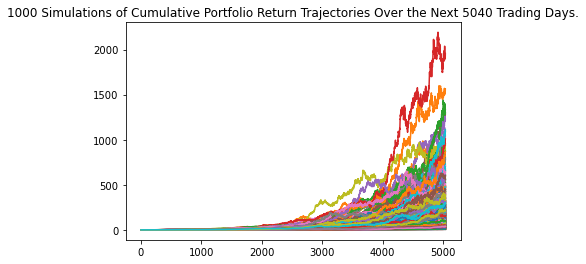

In [22]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 20yr scenario

MC_even_weight_line_20yr_plot = MC_even_weight_20yr.plot_simulation()

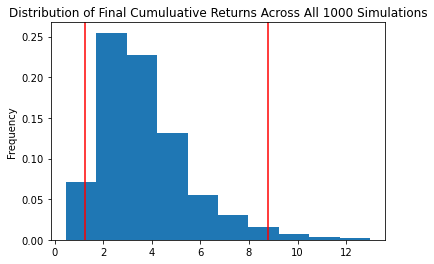

In [23]:
# Here we visualize the probability distribution of the Monte Carlo simulation 
# based on the user's timeframe by plotting a histogram
#Changed on 2021-11-02 by Paul Lopez. We are now plotting for all 3 time horizons of 5yr, 10yr, and 20yr.
MC_even_weight_5yr_distibution_plot = MC_even_weight_5yr.plot_distribution()


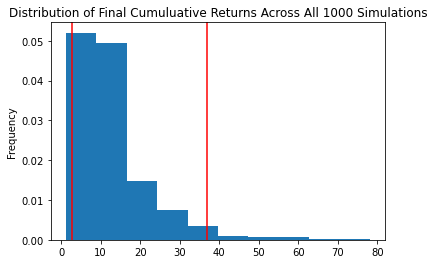

In [24]:
MC_even_weight_10yr_distibution_plot = MC_even_weight_10yr.plot_distribution()


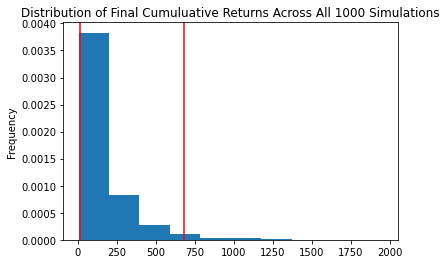

In [25]:
MC_even_weight_20yr_distibution_plot = MC_even_weight_20yr.plot_distribution()


#### Step 4: Generate the summary statistics for the Monte Carlo simulation.

In [26]:
# Generate summary statistics from the Monte Carlo simulation 5yr results
# We save the results as a variable
MC_even_weight_5yr_summary_table = MC_even_weight_5yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_5yr_summary_table)

count           1000.000000
mean               3.698890
std                1.864138
min                0.463595
25%                2.352900
50%                3.325733
75%                4.553121
max               12.980858
95% CI Lower       1.261701
95% CI Upper       8.764887
Name: 1260, dtype: float64


In [27]:
# Generate summary statistics from the Monte Carlo simulation 10yr results
# We save the results as a variable
MC_even_weight_10yr_summary_table = MC_even_weight_10yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_10yr_summary_table)

count           1000.000000
mean              12.797528
std                9.546886
min                1.155824
25%                6.731544
50%               10.372310
75%               15.680024
max               78.195889
95% CI Lower       2.680230
95% CI Upper      36.855505
Name: 2520, dtype: float64


In [28]:
# Generate summary statistics from the Monte Carlo simulation 20yr results
# We save the results as a variable
MC_even_weight_20yr_summary_table = MC_even_weight_20yr.summarize_cumulative_return()


# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_20yr_summary_table)

count           1000.000000
mean             167.191931
std              194.576586
min                5.563924
25%               55.312192
50%              101.908930
75%              204.682489
max             1954.360450
95% CI Lower      15.418602
95% CI Upper     677.596256
Name: 5040, dtype: float64


In [29]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 5 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_5yr} and ${ci_upper_thirty_cumulative_return_5yr}.")


There is a 95% chance that the current value of $5000000.00 in the portfolio with an even 20% weight in each stock over the next 5 years will end within the range of $6308504.41 and $43824435.06.


In [30]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 10 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_10yr} and ${ci_upper_thirty_cumulative_return_10yr}.")


There is a 95% chance that the current value of $5000000.00 in the portfolio with an even 20% weight in each stock over the next 10 years will end within the range of $13401148.4 and $184277522.61.


In [31]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 20 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_20yr} and ${ci_upper_thirty_cumulative_return_20yr}.")


There is a 95% chance that the current value of $5000000.00 in the portfolio with an even 20% weight in each stock over the next 20 years will end within the range of $77093009.81 and $3387981277.73.
